# Breast Cancer Proteomes

The dataset contains published iTRAQ proteome profiling of 77 breast cancer samples generated by the Clinical Proteomic Tumor Analysis Consortium (NCI/NIH). It contains expression values for ~12.000 proteins for each sample, with missing values present when a given protein could not be quantified in a given sample.

###### AIM:
To build ML models to predict various endpoints - AJCC stage, metastasis, tumor stage and PAM50 mRNA type

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import optuna
from imblearn.over_sampling import RandomOverSampler

### Model training - PAM50 mRNA type

In [2]:
final = pd.read_csv("final_data.csv")

Prediction of PAM50 mRNA

PAM50 is a gene expression-based assay used for molecular profiling of breast cancer, derived from the original identification method as determined by Perou et al.   
It is a molecular diagnostic tool that helps classify breast cancer into different intrinsic subtypes based on the expression patterns of 50 genes measured parallel with 8 housekeeping genes.

0 : Basal  
1 : Luminal A  
2 : Luminal B  
3 : HER2  

In [3]:
final.drop(['RefSeq_accession_number','Metastasis-Coded','Tumor','AJCC Stage',"ER Status","PR Status","HER2 Final Status"],axis=True,inplace=True) #removing other targets and sample id

In [4]:
#corelation with the target "PAM50 mRNA"
x = pd.DataFrame(abs(final.corr()["PAM50 mRNA"]))

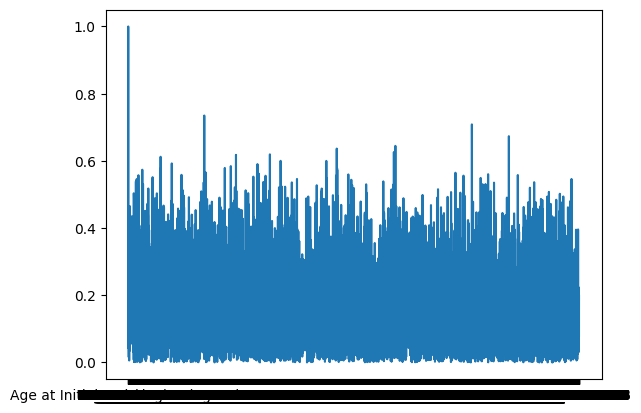

In [7]:
plt.plot(x)

In [6]:
len(x[x["PAM50 mRNA"]>0.2].index.tolist())

2781

In [16]:
x[x["PAM50 mRNA"]>0.2].to_csv("PAM50_feature.txt")

In [7]:
final2 = final[x[x["PAM50 mRNA"]>0.2].index.tolist()] #keeping features above 0.2 corelation, 2781 proteins 

In [8]:
final2.shape

(77, 2781)

In [9]:
scaler = MinMaxScaler() #scaling
final2_scale = pd.DataFrame(scaler.fit_transform(final2.drop('PAM50 mRNA', axis=1)),columns=final2.columns.to_list()[1:])

In [10]:
X = final2_scale
y = final2['PAM50 mRNA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

In [11]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 75.00
Precision: 0.75
Recall: 0.75
F1-Score: 0.75
[[5 0 0 0]
 [1 2 1 1]
 [0 0 6 0]
 [0 2 1 5]]


<BarContainer object of 50 artists>

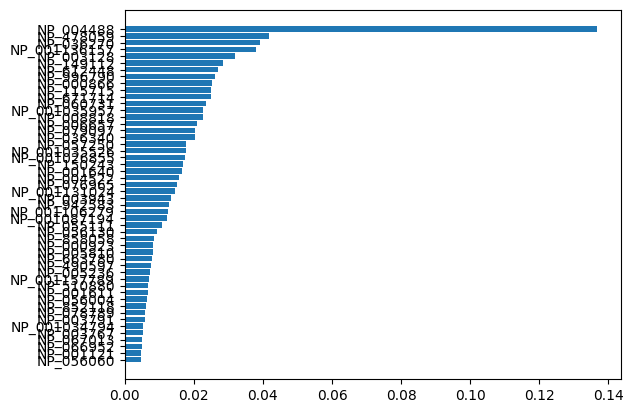

In [96]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2730:2780],xgb.feature_importances_[idx][2730:2780]) #top50

In [97]:
X_train.columns[idx][2730:2780] #top50 proteins in feature importance

Index(['NP_056060', 'NP_001121', 'NP_066952', 'NP_067013', 'NP_003767',
       'NP_001034794', 'NP_003791', 'NP_078789', 'NP_852118', 'NP_056004',
       'NP_001611', 'NP_510880', 'NP_001157789', 'NP_005236', 'NP_490597',
       'NP_663780', 'NP_005810', 'NP_000923', 'NP_858058', 'NP_056130',
       'NP_055111', 'NP_001087194', 'NP_001106279', 'NP_942583', 'NP_003943',
       'NP_001131024', 'NP_076965', 'NP_004522', 'NP_001640', 'NP_150243',
       'NP_001026855', 'NP_001035526', 'NP_057250', 'NP_036340', 'NP_079097',
       'NP_006657', 'NP_008818', 'NP_001035957', 'NP_060731', 'NP_671714',
       'NP_115715', 'NP_000866', 'NP_996790', 'NP_612448', 'NP_149112',
       'NP_003128', 'NP_001136157', 'NP_036270', 'NP_478059', 'NP_004488'],
      dtype='object')

NP_004488:FOXA3 is reported to be cancer hallmark for invasion and metastasis, resisting cell death and tumor proliferative inflammation which also is the most important feature for the model performance

## PC analysis

In [119]:
pca = PCA(n_components=50,random_state=42)
r = pca.fit_transform(X = X_train.values)

In [120]:
component_weights = pca.components_
ex_var = pca.explained_variance_
ex_ratio = pca.explained_variance_ratio_

Text(0.5, 1.0, 'Variance ratio captured by PCs')

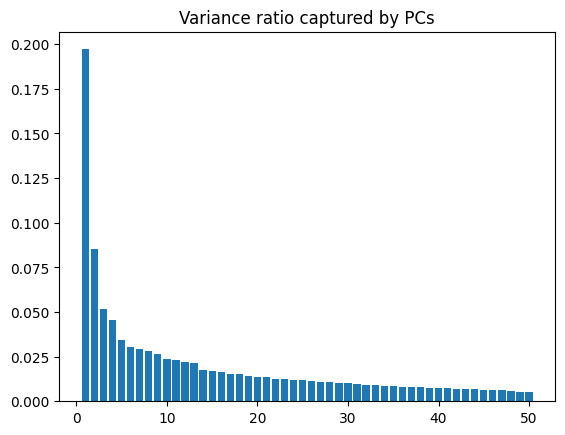

In [121]:
plt.bar(list(range(1,51)),ex_ratio)
plt.title("Variance ratio captured by PCs")

## Hyperparameter tuning - Optuna

In [21]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        #"colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        #"subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
    }
    model = XGBClassifier(**param, eval_metric="logloss")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()

In [149]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

best_params = study.best_trial.params
best_model = XGBClassifier(**best_params, eval_metric="logloss")
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

[I 2025-01-13 22:42:32,387] A new study created in memory with name: no-name-aa3828f8-c2da-4cb9-9610-cfe9a8406f0f
[I 2025-01-13 22:42:59,643] Trial 0 finished with value: 0.450909090909091 and parameters: {'n_estimators': 450, 'max_depth': 16, 'learning_rate': 0.23, 'gamma': 1.8, 'min_child_weight': 5}. Best is trial 0 with value: 0.450909090909091.
[I 2025-01-13 22:43:24,303] Trial 1 finished with value: 0.3618181818181818 and parameters: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.28, 'gamma': 1.7000000000000002, 'min_child_weight': 9}. Best is trial 0 with value: 0.450909090909091.
[I 2025-01-13 22:43:37,861] Trial 2 finished with value: 0.4745454545454545 and parameters: {'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 2.7, 'min_child_weight': 8}. Best is trial 2 with value: 0.4745454545454545.
[I 2025-01-13 22:43:50,058] Trial 3 finished with value: 0.3218181818181818 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.19, 

Best trial:
  Value: 0.5890909090909091
  Params: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 3.2, 'min_child_weight': 7}
Test set accuracy: 0.6667


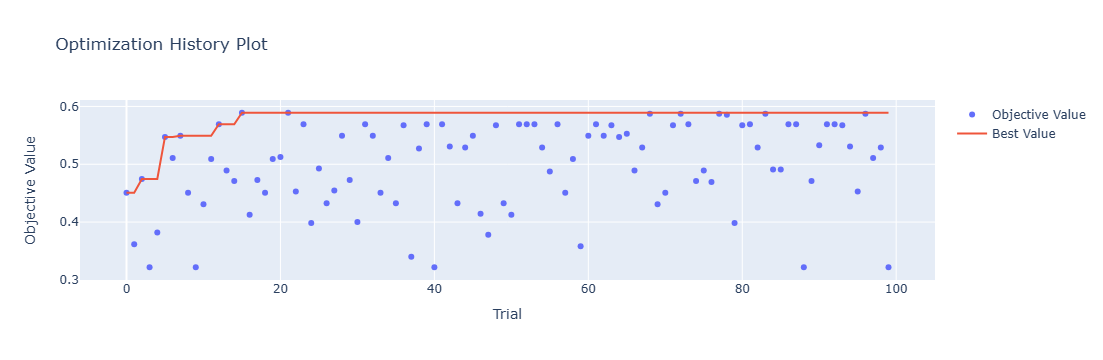

In [151]:
optuna.visualization.plot_optimization_history(study).show()

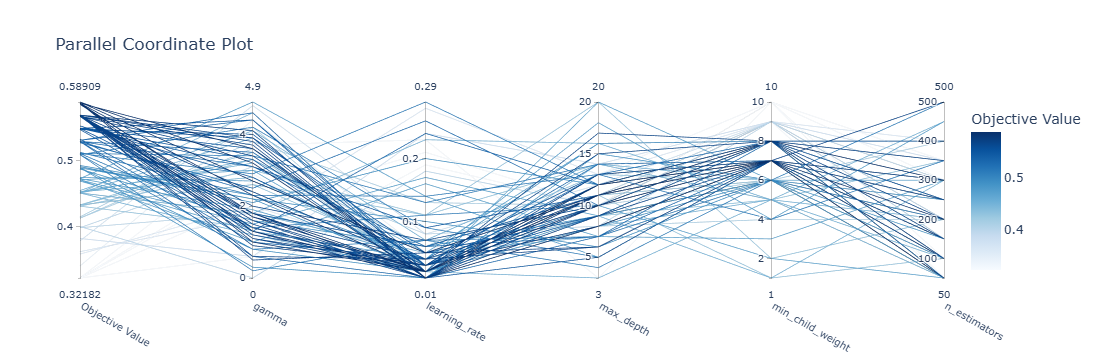

In [152]:
optuna.visualization.plot_parallel_coordinate(study).show()

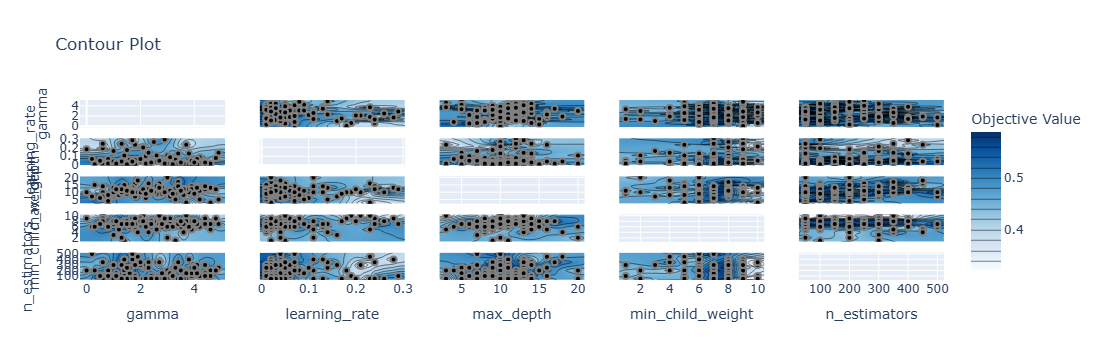

In [156]:
optuna.visualization.plot_contour(study).show()

In [158]:
#optuna.visualization.plot_slice(study).show()

### Model training - Tumor stage

In [17]:
final = pd.read_csv("final_data.csv")

Prediction of Tumor stage 

In [18]:
final.drop(['RefSeq_accession_number','Metastasis-Coded','PAM50 mRNA','AJCC Stage',"ER Status","PR Status","HER2 Final Status"],axis=True,inplace=True) #removing other targets and sample id

In [19]:
#corelation with the target "PAM50 mRNA"
x = pd.DataFrame(abs(final.corr()["Tumor"]))

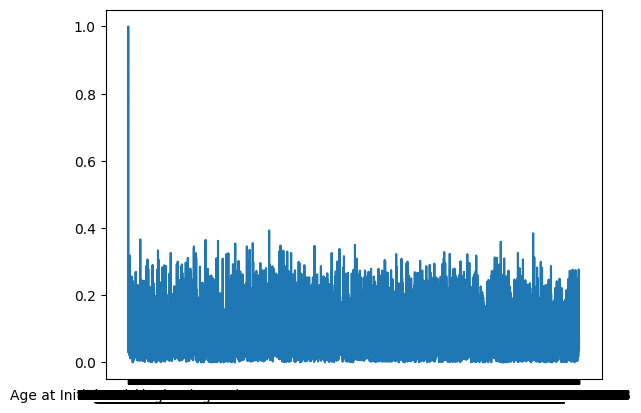

In [162]:
plt.plot(x)

In [20]:
x[x["Tumor"]>0.3].to_csv("Tumor_feature.txt")

In [163]:
final2 = final[x[x["Tumor"]>0.3].index.tolist()] #keeping features above 0.3 corelation, 71 proteins 

In [164]:
scaler = MinMaxScaler() #scaling
final2_scale = pd.DataFrame(scaler.fit_transform(final2.drop('Tumor', axis=1)),columns=final2.columns.to_list()[1:])

In [166]:
X = final2_scale
y = final2['Tumor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [167]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

XGBoost's prediction accuracy is: 75.00
Precision: 0.75
Recall: 0.75
F1-Score: 0.75
[[ 0  2  0  0]
 [ 0 17  0  0]
 [ 0  3  0  0]
 [ 0  1  0  1]]


<BarContainer object of 50 artists>

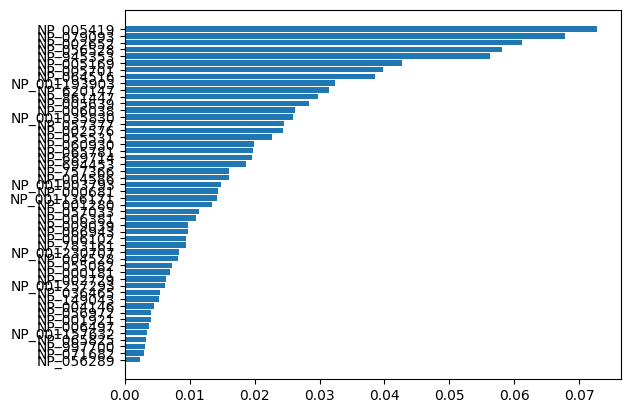

In [168]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx][20:71],xgb.feature_importances_[idx][20:71]) #top50

In [169]:
X_train.columns[idx][20:71] #top50 proteins in feature importance

Index(['NP_056289', 'NP_071682', 'NP_997700', 'NP_065825', 'NP_001157632',
       'NP_006497', 'NP_001921', 'NP_056972', 'NP_004146', 'NP_149043',
       'NP_036465', 'NP_001257293', 'NP_002729', 'NP_000181', 'NP_055082',
       'NP_004528', 'NP_001230707', 'NP_783161', 'NP_006102', 'NP_066943',
       'NP_009039', 'NP_006381', 'NP_057033', 'NP_001280', 'NP_001136171',
       'NP_000681', 'NP_001003793', 'NP_004586', 'NP_757366', 'NP_694453',
       'NP_689714', 'NP_065781', 'NP_060930', 'NP_055531', 'NP_002576',
       'NP_057377', 'NP_001035830', 'NP_006038', 'NP_005639', 'NP_861447',
       'NP_620147', 'NP_001193903', 'NP_064516', 'NP_005701', 'NP_005169',
       'NP_945353', 'NP_056528', 'NP_002652', 'NP_079093', 'NP_005419'],
      dtype='object')

In [170]:
y.value_counts()

1    51
2    11
0    10
3     5
Name: Tumor, dtype: int64

Class imbalance in the tumor stage data, the model might not be robust enough and yet to learn better on the data.  
Hence we follow with an over sampling method to balance the classes

In [173]:
ros = RandomOverSampler(random_state=42)
X2, y2 = ros.fit_resample(X, y)

In [174]:
y2.value_counts()

1    51
0    51
2    51
3    51
Name: Tumor, dtype: int64

In [175]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=30)

In [176]:
xgb2 = XGBClassifier(n_estimators=100)
xgb2.fit(X2_train, y2_train)
preds = xgb2.predict(X2_test)
acc_xgb = (preds == y2_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y2_test, preds, average='micro'))
print("Recall:",recall_score(y2_test, preds, average='micro'))
print("F1-Score:", f1_score(y2_test, preds, average='micro'))
print(confusion_matrix(y2_test, preds))

XGBoost's prediction accuracy is: 96.77
Precision: 0.967741935483871
Recall: 0.967741935483871
F1-Score: 0.967741935483871
[[18  0  0  0]
 [ 2 12  0  0]
 [ 0  0 16  0]
 [ 0  0  0 14]]


Index(['NP_002652', 'NP_071682', 'NP_000681', 'NP_001193903', 'NP_001280',
       'NP_001921', 'NP_006497', 'NP_056528', 'NP_006038', 'NP_001139',
       'NP_064516', 'NP_001035830', 'NP_783161', 'NP_149043', 'NP_001130002',
       'NP_005169', 'NP_009039', 'NP_001230707', 'NP_659412', 'NP_001136171',
       'NP_694453', 'NP_065825', 'NP_001257293', 'NP_997700', 'NP_861447',
       'NP_004586', 'NP_055531', 'NP_004528', 'NP_036465', 'NP_065781',
       'NP_001092108', 'NP_945353', 'NP_001157632', 'NP_620147', 'NP_996896',
       'NP_006381', 'NP_004937', 'NP_060930', 'NP_079093', 'NP_065821',
       'NP_005419', 'NP_073602', 'NP_055082', 'NP_001003793', 'NP_057377',
       'NP_005639', 'NP_115553', 'NP_002576', 'NP_056972', 'NP_056289'],
      dtype='object')


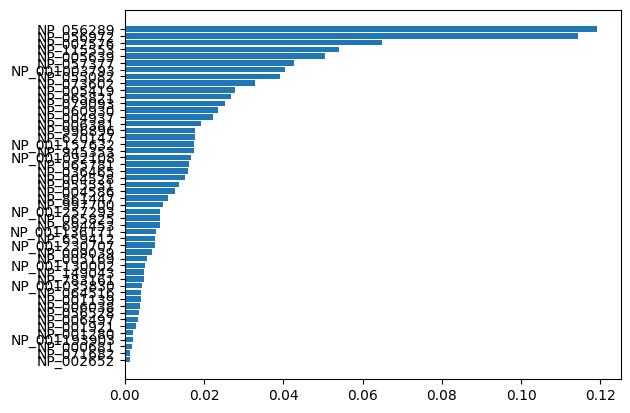

In [177]:
idx2 = xgb2.feature_importances_.argsort()
plt.barh(X2_train.columns[idx2][20:71],xgb2.feature_importances_[idx2][20:71]) #top50
print(X2_train.columns[idx2][20:71]) #top50 proteins in feature importance

Pathway enrichment using top 50 protein w.r.t. importance for the model:  
HIF-1 signaling pathway  
Proteoglycans in cancer  
Chemokine signaling pathway 
B cell receptor signaling pathway  
Fc gamma R-mediated phagocytosis  
Leukocyte transendothelial migration  
Natural killer cell mediated cytotoxicity   